In [1]:
import numpy as np

full_data = np.load('./data/combined_data.npy', allow_pickle=True)
X_train_event, X_test_event, X_train_obj, X_test_obj, y_train, y_test = full_data

Order of columns for combined data:
QCD, TTTo2L2Nu  TTToHadronic  TTToSemiLeptonic  VBF125  WJets WminusH125  WplusH125  ZH125  ZJets  ggF125  ttH125

In [4]:
import tensorflow as tf
from tensorflow import keras

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.set_visible_devices(gpus[0], 'GPU')
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)

2022-03-03 15:51:28.879618: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
all_devices = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", all_devices)

Num GPUs Available:  6


2022-03-03 15:52:17.721842: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-03 15:52:17.724580: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-03 15:52:17.937062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-03 15:52:17.938426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-03 15:52:17.939752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:5f:00.0 name: Tesla T4 computeCapability: 

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, AlphaDropout, Concatenate, LayerNormalization, GRU, Conv1D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import Model
from tensorflow.keras.metrics import AUC, BinaryAccuracy, Precision, Recall, FalsePositives, TruePositives, CategoricalAccuracy
from tensorflow.keras.regularizers import l1, l2, l1_l2
from functools import partial

dense = partial(Dense, units=200, activation="selu", kernel_initializer="lecun_normal")
dropout = partial(AlphaDropout, rate=0.2)

obj_input = Input(shape=X_train_obj.shape[1:])
# conv = Conv1D(filters=30, kernel_size=5, strides=1, padding="same")(obj_input)
gru = GRU(200)(obj_input)
ln = LayerNormalization()(gru)
event_input = Input(shape=X_train_event.shape[1:])
hidden1 = dense(units=50)(event_input)
conc = Concatenate()([ln, hidden1])
# do1 = dropout()(conc)
hidden2 = dense()(conc)
# do2 = dropout()(hidden2)
hidden3 = dense()(hidden2)
# do3 = dropout()(hidden3)
hidden4 = dense()(hidden3)
# do4 = dropout()(hidden4)
hidden5 = dense()(hidden4)
# do5 = dropout()(hidden5)
hidden6 = dense()(hidden5)
hidden7 = dense()(hidden6)
# hidden6 = dense()(do5)
# do6 = dropout()(hidden6)
out = Dense(12, activation="softmax")(hidden7)
combined_model = Model(inputs=[obj_input, event_input], outputs=out)
opt = Nadam(learning_rate=0.001)
metrics = [AUC(name="auc"), CategoricalAccuracy(), Precision(name="precision"), Recall(name="recall")]
combined_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=metrics)

2022-03-03 15:52:22.874623: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-03 15:52:23.697385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-03 15:52:23.698337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-03 15:52:23.699214: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720]

In [12]:
from keras.models import Sequential

conv_model = Sequential([
    keras.layers.Conv1D(filters=13, kernel_size=4, strides=2, padding="valid", input_shape=X_train_obj.shape[1:]),
    keras.layers.GRU(200, return_sequences=True),
    keras.layers.GRU(200),
    Dense(1, activation="sigmoid")
])
conv_model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=[keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.BinaryAccuracy()])
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 13)             377       
_________________________________________________________________
gru_6 (GRU)                  (None, 6, 200)            129000    
_________________________________________________________________
gru_7 (GRU)                  (None, 200)               241200    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 370,778
Trainable params: 370,778
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Imbalanced dataset so want to adjusts weights of signal and background training examples
tot = len(y_train)
pos = np.sum(y_train['ttH125'])
neg = tot - pos
print(f'Total training samples:  {tot}\npositives:  {pos}\nnegatives:  {neg}')

# weight positives more than negatives
weight_for_0 = (1 / neg) * (tot / 2.0)
weight_for_1 = (1 / pos) * (tot / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'Postive weight:  {weight_for_1} \nNegative weight:  {weight_for_0}')

sample_weights = np.array([class_weight[i] for i in y_test.values[:,-1]])

Total training samples:  327177
positives:  79444
negatives:  247733
Postive weight:  2.0591674638739237 
Negative weight:  0.660341981084474


In [4]:
#oversample

y_train = y_train.values

pos = y_train[:,-1]==1

ids = np.where(pos)[0]
choices = np.random.choice(ids, len(y_train) - np.sum(pos))

pos_features_event, pos_features_obj = X_train_event[choices], X_train_obj[choices]
res_pos_labels = y_train[choices]
print(pos_features_event.shape, pos_features_obj.shape)

resampled_event = np.concatenate([X_train_event[~pos], pos_features_event], axis=0)
resampled_obj = np.concatenate([X_train_obj[~pos], pos_features_obj], axis=0)

neg_labels = y_train[~pos]
resampled_labels = np.concatenate([neg_labels, res_pos_labels,])
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_labels = resampled_labels[order]
resampled_event = resampled_event[order]
resampled_obj = resampled_obj[order]

print(resampled_obj.shape, resampled_event.shape)

(247733, 11) (247733, 14, 7)
(495466, 14, 7) (495466, 11)


In [7]:
from sklearn.utils import class_weight

# y_train, y_test = y_train.values, y_test.values  # np arrays for ease
# hadronics_obj, hadronics_event, hadronics_labels = (
#     np.repeat(X_train_obj[y_train[:, 1] == 1], 50, axis=0),
#     np.repeat(X_train_event[y_train[:, 1] == 1], 50, axis=0),
#     np.repeat(y_train[y_train[:, 1] == 1], 50, axis=0),
# )
# X_train_obj, X_train_event, y_train = (
#     np.concatenate([X_train_obj, hadronics_obj]),
#     np.concatenate([X_train_event, hadronics_event]),
#     np.concatenate([y_train, hadronics_labels]),
# )
# indices = np.random.permutation(len(X_train_obj))
# X_train_obj, X_train_event, y_train = (
#     X_train_obj[indices],
#     X_train_event[indices],
#     y_train[indices],
# )
# weight positives more than negatives
# sample_weights = class_weight.compute_sample_weight(
#     class_weight="balanced",
#     y=y_train,
# )
# test_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_test)

y_integers = np.argmax(y_train.values, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights


{0: 1665.0204402515724,
 1: 16.66750086567822,
 2: 1076.1717479674796,
 3: 0.7447523922452293,
 4: 50.05449990546417,
 5: 0.42156745657343997,
 6: 11.039039696438996,
 7: 9.586755386565272,
 8: 10.747300369423131,
 9: 0.17265980953424456,
 10: 0.5974218888396187,
 11: 2.221592148767266}

In [8]:
train_weights = np.array([d_class_weights[i] for i in np.argmax(y_train.values, axis=1)])
test_weights = np.array([d_class_weights[i] for i in np.argmax(y_test.values, axis=1)])

In [13]:
set(train_weights)

{0.17265980953424456,
 0.42156745657343997,
 0.5974218888396187,
 0.7447523922452293,
 2.221592148767266,
 9.586755386565272,
 10.747300369423131,
 11.039039696438996,
 16.66750086567822,
 50.05449990546417,
 1076.1717479674796,
 1665.0204402515724}

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

lr_scedueler = ReduceLROnPlateau(patience=1, factor=0.1)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = combined_model.fit([X_train_obj, X_train_event], y_train.values, epochs=50, 
        validation_data=([X_test_obj, X_test_event], y_test.values, test_weights), 
        batch_size=128, callbacks=[early_stop, lr_scedueler], shuffle=True, sample_weight=train_weights)

2022-03-03 15:55:50.182178: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-03 15:55:50.182853: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


Epoch 1/50


2022-03-03 15:55:53.070857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-03 15:55:53.438823: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


16547/16547 [==============================] - 234s 14ms/step - loss: 3.6346 - auc: 0.6819 - categorical_accuracy: 0.1613 - precision: 0.1799 - recall: 0.0361 - val_loss: 2.8759 - val_auc: 0.6420 - val_categorical_accuracy: 0.1469 - val_precision: 0.2714 - val_recall: 0.0601
Epoch 2/50
16547/16547 [==============================] - 177s 11ms/step - loss: 3.1331 - auc: 0.7002 - categorical_accuracy: 0.1808 - precision: 0.2363 - recall: 0.0493 - val_loss: 3.1980 - val_auc: 0.6719 - val_categorical_accuracy: 0.1113 - val_precision: 0.0701 - val_recall: 0.0165
Epoch 3/50
16547/16547 [==============================] - 172s 10ms/step - loss: 2.2153 - auc: 0.7620 - categorical_accuracy: 0.2343 - precision: 0.3648 - recall: 0.0514 - val_loss: 2.1204 - val_auc: 0.7841 - val_categorical_accuracy: 0.2616 - val_precision: 0.3712 - val_recall: 0.0530
Epoch 4/50
16547/16547 [==============================] - 195s 12ms/step - loss: 1.9880 - auc: 0.8026 - categorical_accuracy: 0.2791 - precision: 0.39

KeyboardInterrupt: 

In [23]:
combined_model.save("./models/combined_all_data_mar3")

2022-03-03 17:00:12.185471: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/combined_all_data_mar3/assets


INFO:tensorflow:Assets written to: ./models/combined_all_data_mar3/assets


In [6]:
combined_model = keras.models.load_model("./models/combined_all_data_mar3")

In [15]:
combined_model.save('./models/combined_feb_26')

2022-02-26 13:14:38.856033: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/combined_feb_26/assets


INFO:tensorflow:Assets written to: ./models/combined_feb_26/assets


In [20]:
combined_model_ = keras.models.load_model('./feb_11')
combined_model_.summary()

OSError: SavedModel file does not exist at: ./feb_11/{saved_model.pbtxt|saved_model.pb}

In [8]:
history.history.keys()

dict_keys(['loss', 'auc', 'binary_accuracy', 'precision', 'recall', 'false_positives', 'true_positives', 'val_loss', 'val_auc', 'val_binary_accuracy', 'val_precision', 'val_recall', 'val_false_positives', 'val_true_positives', 'lr'])

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss'])+1)

plt.plot(epochs, history.history['loss'], label='Training')
plt.plot(epochs, history.history['val_loss'], label='Validation')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("./first_lstm_loss.png", dpi=200)
plt.show()

plt.plot(epochs, history.history['categorical_accuracy'], label='Training')
plt.plot(epochs, history.history['val_categorical_accuracy'], label='Validation')
plt.ylabel("Categorical accuracy")
plt.xlabel("epoch")
plt.legend()
# plt.savefig("./first_lstm_accuracy.png", dpi=200)
plt.show()

plt.plot(epochs, history.history['auc'], label='Training')
plt.plot(epochs, history.history['val_auc'], label='Validation')
plt.ylabel("AUC")
plt.xlabel("epoch")
plt.legend()
# plt.savefig("./first_lstm_AUC.png", dpi=200)
plt.show()

plt.plot(epochs, history.history['recall'], label='Training')
plt.plot(epochs, history.history['val_recall'], label='Validation')
plt.ylabel('Recall')
plt.xlabel("epoch")
plt.legend()
# plt.savefig("./first_lstm_recall.png", dpi=200)
plt.show()

plt.plot(epochs, history.history['precision'], label='Training')
plt.plot(epochs, history.history['val_precision'], label='Validation')
plt.ylabel("precision")
plt.xlabel("epoch")
plt.legend()
# plt.savefig("./first_lstm_precision.png", dpi=200)
plt.show()

NameError: name 'history' is not defined

In [10]:
#Model predictions
# with keras.backend.learning_phase_scope(1): 
#     y_probas = np.stack([combined_model.predict([X_test_obj, X_test_event]) for sample in range(100)]) 
#     y_pred = y_probas.mean(axis=0)

y_pred = combined_model.predict([X_test_obj, X_test_event])
y_train_pred = combined_model.predict([X_train_obj, X_train_event])

In [21]:
y_pred

array([[2.3165751e-01, 5.0585173e-02, 7.3113218e-03, ..., 2.5645394e-02,
        7.2669992e-03, 5.2891976e-01],
       [1.2344250e-02, 8.5210398e-02, 3.2318904e-04, ..., 1.4136750e-01,
        2.2761509e-01, 5.2820789e-03],
       [2.8395604e-02, 6.1246526e-01, 2.0722870e-02, ..., 3.2708291e-02,
        4.1593671e-02, 1.1141467e-02],
       ...,
       [1.0068679e-01, 9.6369341e-02, 1.2446763e-01, ..., 3.6775988e-02,
        4.6173841e-02, 4.0945530e-02],
       [2.5402203e-02, 3.0849162e-02, 3.0173934e-03, ..., 8.1309140e-02,
        1.3100772e-01, 1.1095148e-02],
       [1.6027415e-02, 2.9054862e-01, 2.9233795e-01, ..., 3.7293811e-03,
        1.7950024e-03, 1.2186374e-01]], dtype=float32)

In [ ]:
np.save("./y_pred_feb_11.npy", y_pred)

In [54]:
y_pred = np.load("./y_pred_feb_11.npy")
y_pred

array([[0.5485497 ],
       [0.23549275],
       [0.30994406],
       ...,
       [0.09543934],
       [0.68062174],
       [0.00749332]], dtype=float32)

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(resampled_event, y_train_resampled)
lr_predictions = lr.predict_proba(X_test_event)[:,1]

In [19]:
y_pred = combined_model.predict([X_test_obj, X_test_event])
y_pred = y_pred.reshape(y_pred.shape[0])

ValueError: cannot reshape array of size 327180 into shape (81795,)

In [11]:
# Analysis

thresholds = np.arange(0, 1.0001, 0.0001)
FP = np.zeros(len(thresholds))
FN = np.zeros(len(thresholds))
TP = np.zeros(len(thresholds))
TN = np.zeros(len(thresholds))
lr_FP = np.zeros(len(thresholds))
lr_TP = np.zeros(len(thresholds))

test = y_test.values[:,-1]
y_pred = y_pred[:,-1].reshape(len(test))

for idx, threshold in enumerate(thresholds):
    # FP[idx] = ((y_test[y_test['ttH125'] == 0]) & (y_pred >= threshold)).sum()
    # FN[idx] = ((y_test[y_test['ttH125'] == 1]) & (y_pred < threshold)).sum()
    # TP[idx] = ((y_test[y_test['ttH125'] == 1]) & (y_pred >= threshold)).sum()
    # TN[idx] = ((y_test[y_test['ttH125'] == 0]) & (y_pred < threshold)).sum()
    # FP[idx] = len(y_test[(y_test['ttH125']==0) & (y_test['Predictions'] >= threshold)])
    # FN[idx] = len(y_test[(y_test['ttH125']==1) & (y_test['Predictions'] < threshold)])
    # TP[idx] = len(y_test[(y_test['ttH125']==1) & (y_test['Predictions'] >= threshold)])
    # TN[idx] = len(y_test[(y_test['ttH125']==0) & (y_test['Predictions'] < threshold)])
    FP[idx] = ((y_pred >= threshold) & (test==0)).sum()
    FN[idx] = ((y_pred < threshold) & (test==1)).sum()
    TP[idx] = ((y_pred >= threshold) & (test==1)).sum()
    TN[idx] = ((y_pred < threshold) & (test==0)).sum()

    # lr_FP[idx] = ((lr_predictions >= threshold) & (test==0)).sum()
    # lr_TP[idx] = ((lr_predictions >= threshold) & (test==1)).sum()


In [24]:
y_test

,QCD,TTTo2L2Nu,TTToHadronic,TTToSemiLeptonic,VBF125,WJets,WminusH125,WplusH125,ZH125,ZJets,ggF125,ttH125
736203,0,0,0,0,0,0,0,0,0,0,0,1
314278,0,0,0,0,0,0,0,0,0,0,1,0
1250378,0,0,0,0,0,0,0,0,0,1,0,0
713239,0,0,0,0,0,0,0,0,0,0,0,1
1728312,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1193991,0,0,0,0,0,0,0,0,0,1,0,0
2468115,0,0,0,0,0,1,0,0,0,0,0,0
105015,0,0,0,1,0,0,0,0,0,0,0,0
939433,0,0,0,0,0,0,0,0,0,1,0,0


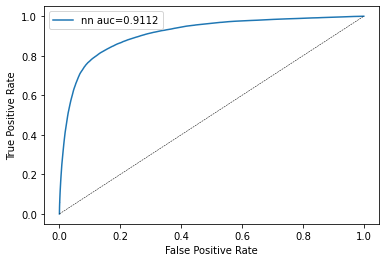

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test.values[:,-1], y_pred)
# ROC curve
tpr = TP/(np.sum(test))
fpr = FP/(len(test) - np.sum(test))
# tpr_lr = lr_TP/np.sum(test)
# fpr_lr = lr_FP/(len(test)-np.sum(test))
plt.plot(fpr, tpr, label=f'nn auc={auc:.4f}')
plt.plot(np.arange(0, 1.0001, 0.0001), np.arange(0, 1.0001, 0.0001), linestyle='dashed', linewidth=0.5, color='k')
# plt.plot(fpr_lr,tpr_lr, label='lr auc=0.796')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
# plt.savefig("./first_lstm_vs_lr_ROC.png", dpi=200)
plt.show()

In [13]:
f1 = TP/(TP+0.5*(FP+FN))
best_f1_idx = np.argmax(f1)
print(thresholds[best_f1_idx])

0.31670000000000004


In [14]:
np.max(f1)

0.45459185843719424

In [38]:
np.argmax(f1)

707

In [15]:
# Significance

# load xs weights
train_weights, test_weights = np.load('./data/combined_xs_weights.npy', allow_pickle=True)

# Get predictions for combined dataset
# y_pred_train = combined_model.predict([X_train_obj, X_train_event])
# y_total = np.concatenate([y_train, y_test])
# y_pred_train = y_pred_train.reshape(y_train.shape)
# y_pred_total = np.concatenate([y_pred_train, y_pred])

In [21]:
total_weights = np.concatenate([train_weights, test_weights])

In [8]:
significance = np.zeros(len(thresholds), dtype=float)
lum = 140e3
sg = np.zeros(len(thresholds))
bg = np.zeros(len(thresholds))
sigma = 0.05

for idx, threshold in enumerate(thresholds):
    sg[idx] = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 1)).astype(int)).sum()
    bg[idx] = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 0)).astype(int)).sum()
    if bg[idx] > 0:
        significance[idx] = sg[idx]/np.sqrt(bg[idx] + (sigma * bg[idx])**2)
    else:
        end_idx = idx
    # print(f"Signal events surviving cut:  {sg[idx]}\nBackground events surviving cut:  {bg[idx]}\nCorresponding siginificance is:  {significance[idx]}")

NameError: name 'total_weights' is not defined

In [16]:
significance_sigma0 = np.zeros(len(thresholds))
significance_sigma5 = np.zeros(len(thresholds))
significance_sigma10 = np.zeros(len(thresholds))

lum = 140e3
sg = np.zeros(len(thresholds))
bg = np.zeros(len(thresholds))
sigma = 0.1

for idx, threshold in enumerate(thresholds):
    sg[idx] = (lum * test_weights * 5 * ((y_pred >= threshold) & (test == 1)).astype(int)).sum()
    bg[idx] = (lum * test_weights * 5 * ((y_pred >= threshold) & (test == 0)).astype(int)).sum()
    if bg[idx] > 0:
        significance_sigma0[idx] = sg[idx]/np.sqrt(bg[idx])
        significance_sigma5[idx] = sg[idx]/np.sqrt(bg[idx] + (0.05 * bg[idx])**2)
        significance_sigma10[idx] = sg[idx]/np.sqrt(bg[idx] + (0.1 * bg[idx])**2)
    
    # print(f"Signal events surviving cut:  {sg[idx]}\nBackground events surviving cut:  {bg[idx]}\nCorresponding siginificance is:  {significance[idx]}")

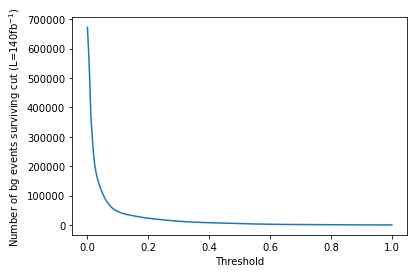

In [17]:
import matplotlib.pyplot as plt

plt.plot(thresholds, bg)
# plt.plot(thresholds, np.sqrt(bg), label="sqrt backgrounds")
plt.xlabel("Threshold")
plt.ylabel(r"Number of bg events surviving cut (L=140fb$^{-1}$)")
# plt.savefig("./first_lstm_bg_surviving.png", dpi=200)
plt.show()

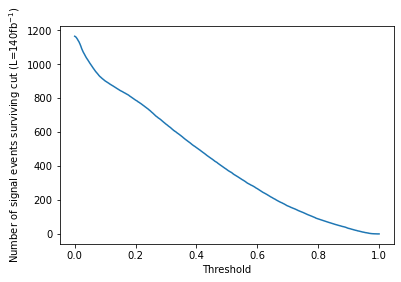

In [18]:
plt.plot(thresholds, sg)
plt.xlabel("Threshold")
plt.ylabel(r"Number of signal events surviving cut (L=140fb$^{-1}$)")
# plt.savefig("./first_lstm_sg_surviving.png", dpi=200)
plt.show()

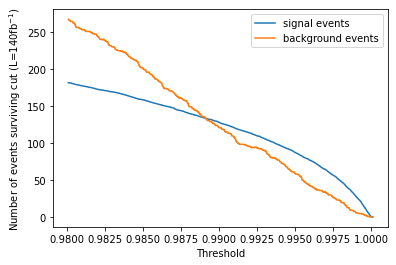

In [20]:
plt.plot(thresholds[-2000:], sg[-2000:], label="signal events")
plt.plot(thresholds[-2000:], bg[-2000:], label="background events")
plt.xlabel("Threshold")
plt.ylabel(r"Number of events surviving cut (L=140fb$^{-1}$)")
plt.legend()
plt.show()

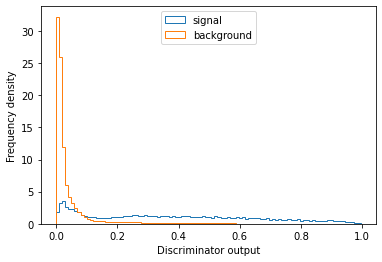

In [19]:
hist, bins, patches = plt.hist(y_pred[test==1], bins=100, density=True, histtype='step', label="signal")
hist_, bins, patches = plt.hist(y_pred[test==0], bins=bins, density=True, histtype='step', label="background")
plt.xlabel("Discriminator output")
plt.ylabel("Frequency density")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist, linewidth=1.2, label="signal")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist_, linewidth=1.2, label="background")
plt.legend(loc="upper center")
# plt.savefig("./first_lstm_Discriminator_test_set.png", dpi=200)
plt.show()

In [46]:
y_pred_train = combined_model.predict([X_train_obj, X_train_event])
y_pred_train = y_pred_train.reshape(y_pred_train.shape[0])
y_pred_train

array([0.13013582, 0.27140203, 0.02773401, ..., 0.9992113 , 0.0792082 ,
       0.92337644], dtype=float32)

In [6]:
import matplotlib.pyplot as plt

hist_sg, bins, patches = plt.hist(y_pred_train[y_train.values[:,-1]==1], histtype='step', label="signal", density=True, bins='auto')
hist_bg, bins, patches = plt.hist(y_pred_train[y_train.values[:,-1]==0], histtype='step', label="background", density=True, bins=bins)
plt.ylabel("Frequency density (sg and bg individually normalised)")
plt.legend()
plt.show()

hist_sg_counts, bins_counts, patches = plt.hist(y_pred_train[y_train.values[:,-1]==1], histtype='step', label="signal", bins='auto')
hist_bg_counts, bins_counts, patches = plt.hist(y_pred_train[y_train.values[:,-1]==0], histtype='step', label="background", bins=bins_counts)
plt.ylabel("Number of samples")
plt.legend()
plt.show()


NameError: name 'y_pred_train' is not defined

In [10]:
thresh = 0.8
labels = y_train.values[:,-1]
# y_pred_train = y_pred_train.reshape(labels.shape)
tp = (labels==1) & (y_pred_train >= thresh)
fp = (labels==0) & (y_pred_train >= thresh)



NameError: name 'labels' is not defined

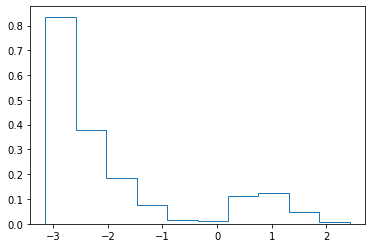

In [26]:
import pandas as pd

X_train_df = pd.read_hdf("./data/X_train_combined.hd5")
X_train_df_event = X_train_df.select_dtypes(exclude=object)
X_train_df_event = X_train_df_event.values

columns = ['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'ncleanedBJet', 'ncleanedJet']

thresh = 0.999
for idx, column in enumerate(columns):
    if column in ['DiJet_mass', 'HT', 'InputMet_pt', 'MHT_pt']:
        log = True
    else:
        log = False
    if column == 'ncleanedBJet':
        bins = range(5)
    elif column == 'ncleanedJet':
        bins = range(2, 15)
    else:
        bins = 10
    # hist, bins, patches = plt.hist(X_train_df_event[:,idx][tp], log=log, bins=bins, label="True positives", histtype="step")
    # hist_, bins, patches = plt.hist(X_train_df_event[:,idx][fp], log=log, bins=bins, label="False positives", histtype="step")
    hist, bins, patches = plt.hist(X_train_df_event[:,idx][y_pred_train >= thresh], log=log, label=f"Surviving cut @ {thresh} threshold", histtype="step", density=True)
    plt.hist(X_train_df_event[:,idx][labels==0], log=log, bins=bins, label="Background", histtype="step", density=True)
    plt.hist(X_train_df_event[:,idx][labels==1], log=log, bins=bins, label="signal", histtype="step", density=True)
    # plt.hist(X_train_df_event[:,idx][tp], log=log, bins=bins, label="True positives", histtype="step", density=True)
    # plt.hist(X_train_df_event[:,idx][fp], log=log, bins=bins, label="False positives", histtype="step", density=True)
    plt.xlabel(column)
    plt.ylabel("Frequency Density")
    plt.legend()
    plt.show()    

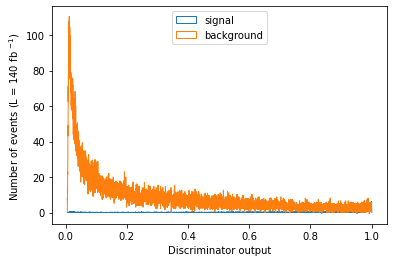

In [74]:
import matplotlib.pyplot as plt

lum = 140e3

hist, bins, patches = plt.hist(y_pred[test==1], weights=5*lum*test_weights[test==1], bins=5000, histtype='step', label="signal")
hist_, bins, patches = plt.hist(y_pred[test==0], weights=5*lum*test_weights[test==0], bins=bins, histtype='step', label="background")
plt.xlabel("Discriminator output")
plt.ylabel(r"Number of events (L = 140 fb $^{-1}$) ")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist, linewidth=1.2, label="signal")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist_, linewidth=1.2, label="background")
plt.legend(loc="upper center")
# plt.savefig("./first_lstm_Discriminator_test_set_xs.png", dpi=200)
plt.show()

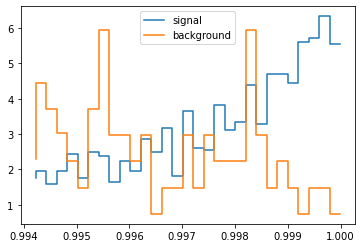

In [75]:
plt.step(bins[-30:], hist[-30:], label="signal")
plt.step(bins[-30:], hist_[-30:], label="background")
plt.legend()
plt.show()

<BarContainer object of 3 artists>

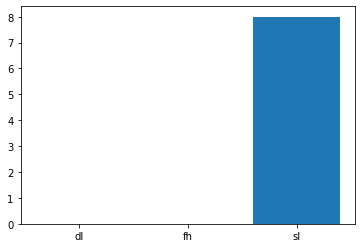

In [24]:
thresh = 0.999
plt.bar(['dl', 'fh', 'sl'], [np.sum(y_test[y_pred >= thresh][:,i]) for i in range(3)])

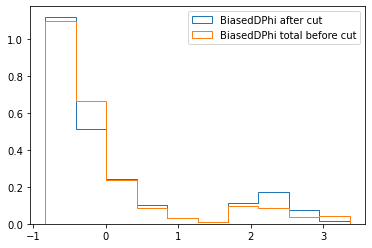

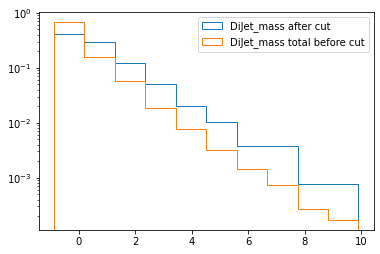

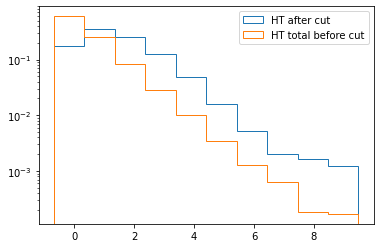

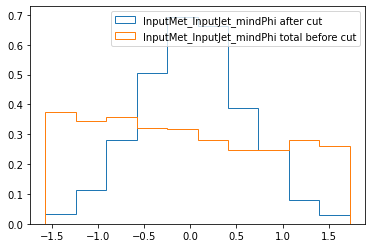

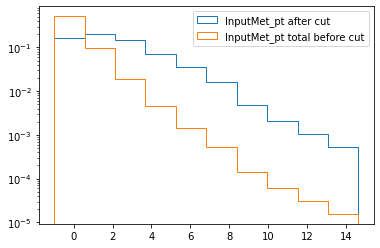

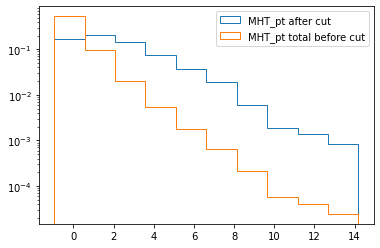

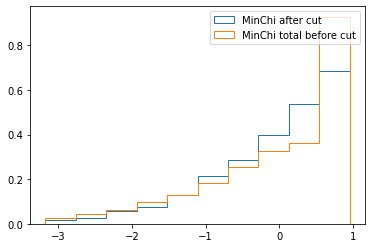

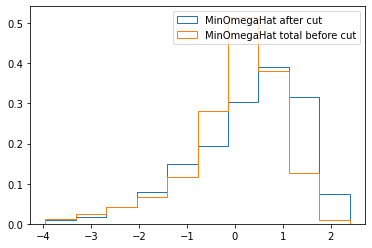

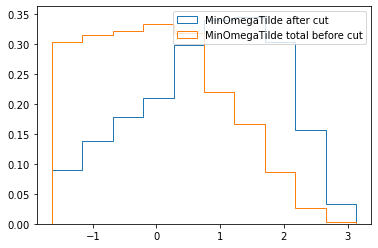

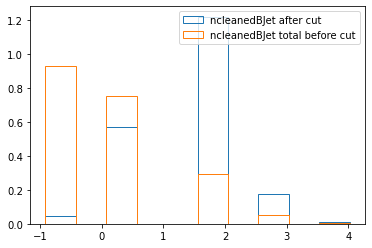

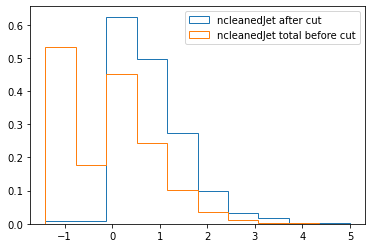

In [106]:
columns = ['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'ncleanedBJet', 'ncleanedJet']
for idx, column in enumerate(columns):
    if column in ('HT', 'InputMet_pt', 'MHT_pt', 'DiJet_mass'):
        log = True
    else:
        log = False
    hist, bins, patches = plt.hist(X_test_event[y_pred >= thresh][:, idx], label=f'{column} after cut', log=log, density=True, histtype="step")
    plt.hist(X_test_event[:, idx], label=f'{column} total before cut', log=log, density=True, histtype="step", bins=bins)
    plt.legend()
    plt.show()

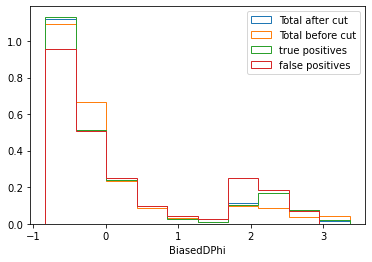

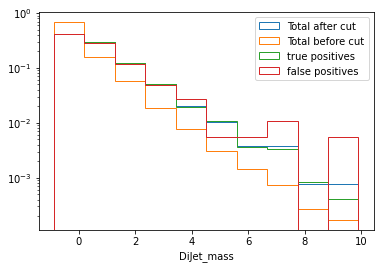

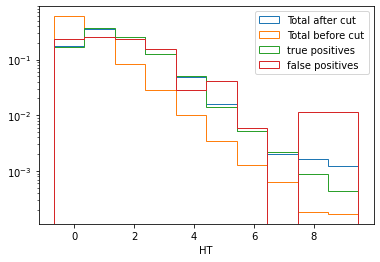

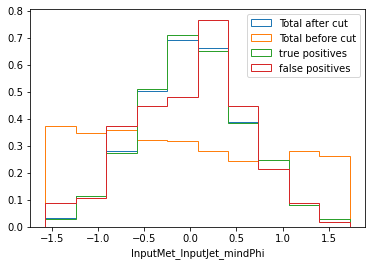

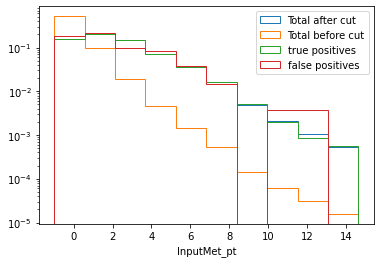

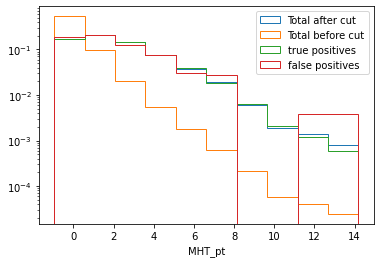

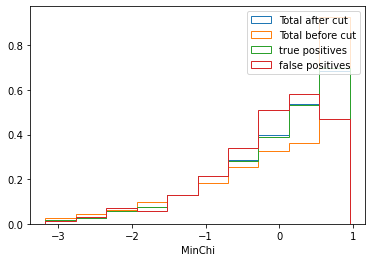

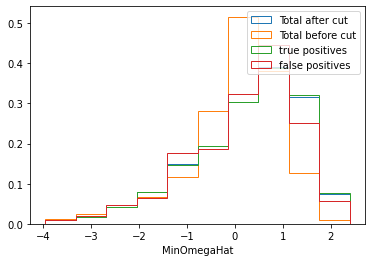

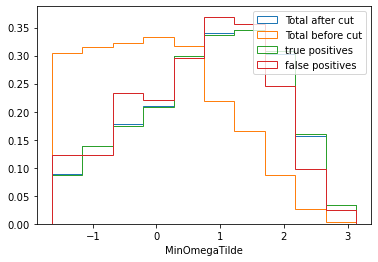

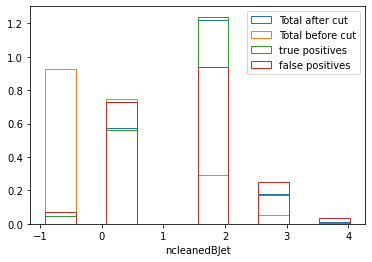

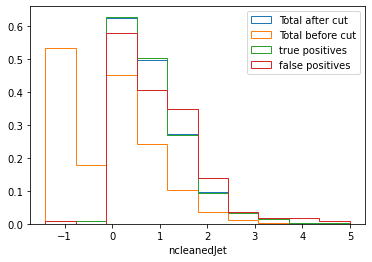

In [113]:
for idx, column in enumerate(columns):
    if column in ('HT', 'InputMet_pt', 'MHT_pt', 'DiJet_mass'):
        log = True
    else:
        log = False
    hist, bins, patches = plt.hist(X_test_event[y_pred >= thresh][:, idx], label=f'Total after cut', log=log, density=True, histtype="step")
    plt.hist(X_test_event[:, idx], label=f'Total before cut', log=log, density=True, histtype="step", bins=bins)
    plt.hist(X_test_event[(y_pred >= thresh) & (test==1)][:, idx], label=f"true positives", log=log, density=True, histtype="step", bins=bins)
    plt.hist(X_test_event[(y_pred >= thresh) & (test==0)][:, idx], label=f"false positives", log=log, density=True, histtype="step", bins=bins)
    plt.xlabel(column)
    plt.legend()
    plt.show()

In [1]:
import pandas as pd

X_test_df = pd.read_hdf("./X_test_combined.hd5")

In [25]:
X_test_df_event = X_test_df.select_dtypes(exclude=object)
X_test_df_event = X_test_df_event.values

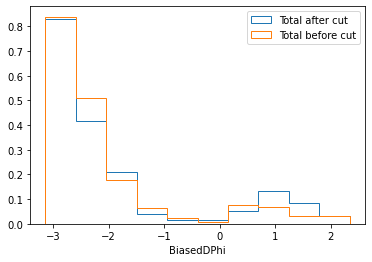

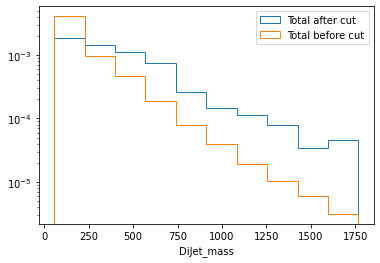

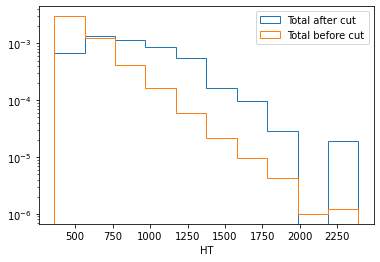

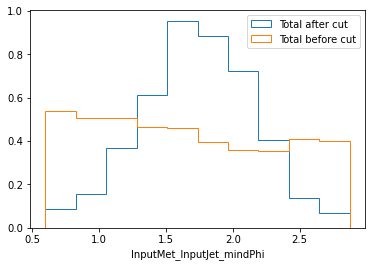

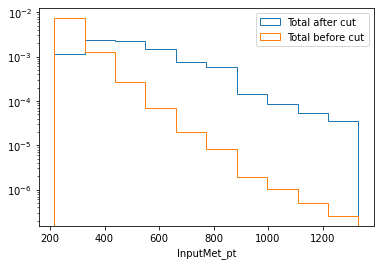

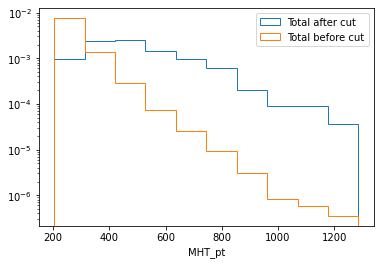

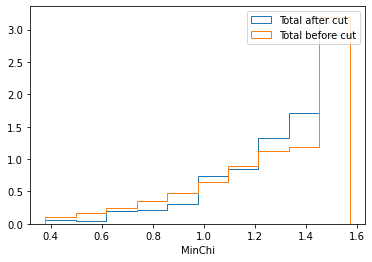

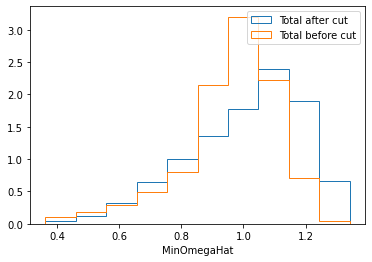

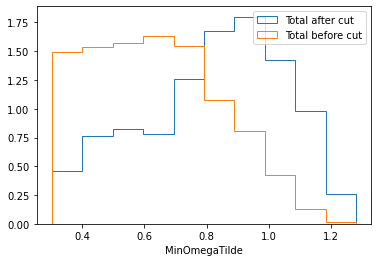

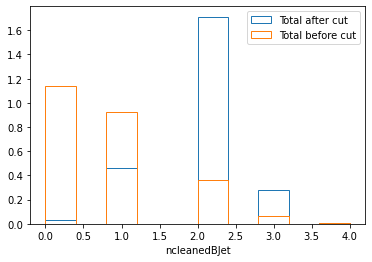

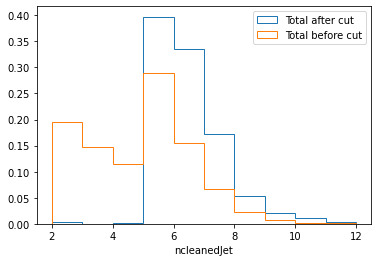

In [27]:
columns = ['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'ncleanedBJet', 'ncleanedJet']

for idx, column in enumerate(columns):
       if column in ('HT', 'InputMet_pt', 'MHT_pt', 'DiJet_mass'):
              log = True
       else:
              log = False
       hist, bins, patches = plt.hist(X_test_df_event[y_pred >= thresh][:, idx], label=f'Total after cut', log=log, density=True, histtype="step")
       plt.hist(X_test_df_event[:, idx], label=f'Total before cut', log=log, density=True, histtype="step", bins=bins)
       # plt.hist(X_test_df_event[(y_pred >= thresh) & (test==1)][:, idx], label=f"true positives", log=log, density=True, histtype="step", bins=bins)
       # plt.hist(X_test_df_event[(y_pred >= thresh) & (test==0)][:, idx], label=f"false positives", log=log, density=True, histtype="step", bins=bins)
       plt.xlabel(column)
       plt.legend()
       plt.show()
       

In [31]:
print(f"Events in last bin: Signal = {hist[-1]},  background = {hist_[-1]}")

Events in last bin: Signal = 77.61056518554688,  background = 58.578125


In [35]:
print(np.sum(hist[-2:]), np.sum(hist_[-2:]))

114.49840927124023 115.1640625


In [44]:
idx = np.argmin(abs(tpr - 0.79))
significance_sigma0[idx]

7.964649271877132

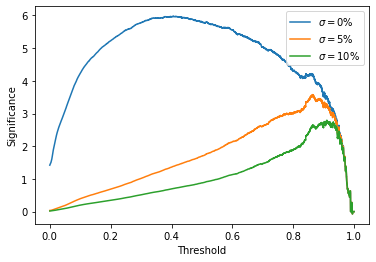

In [20]:
import matplotlib.pyplot as plt

plt.plot(thresholds, significance_sigma0, label=r"$\sigma=0\%$")
plt.plot(thresholds, significance_sigma5, label=r"$\sigma=5\%$")
plt.plot(thresholds, significance_sigma10, label=r"$\sigma=10\%$")
# plt.vlines(thresholds[np.argmax(significance)], linestyles="dashed", color='k', ymin=0, ymax=np.max(significance), linewidth=0.8,
#     label=f"Best threshold = {round(thresholds[np.argmax(significance[:end_idx])], 2)}")
# plt.hlines(np.max(significance), linestyles="dashed", color="k", xmin=0, xmax=1.0, linewidth=0.8)
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()

# plt.savefig("./first_lstm_significance_different_sigmas.png", dpi=200)
plt.legend()
plt.show()

In [29]:
idx_sig5 = np.argmin(abs(significance_sigma5-5))
thresholds[idx_sig5]

0.971

Best threshold for sigma=0% is 0.40490000000000004, significance=5.976946754007136 
Best threshold for sigma=5% is 0.8639, significance=3.5799378726780064 
Best threshold for sigma=10% is 0.9104000000000001, significance=2.7957678442479357


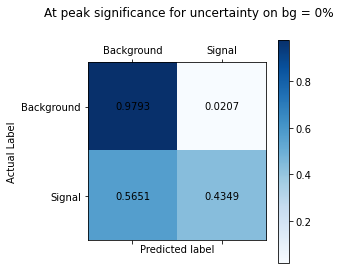

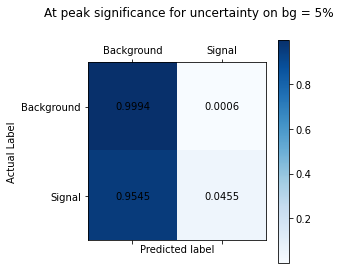

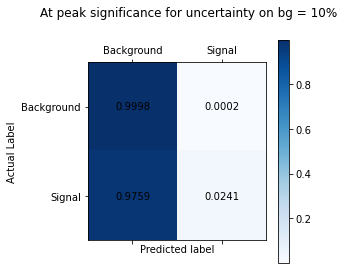

In [21]:
idx_0, idx_5, idx_10 = np.argmax(significance_sigma0), np.argmax(significance_sigma5), np.argmax(significance_sigma10)
print(f"Best threshold for sigma=0% is {thresholds[idx_0]}, significance={significance_sigma0[idx_0]} \nBest threshold for sigma=5% is {thresholds[idx_5]}, significance={significance_sigma5[idx_5]} \nBest threshold for sigma=10% is {thresholds[idx_10]}, significance={significance_sigma10[idx_10]}")
label = {0: 0, 1: 5, 2:10}
# idx_sig5 = np.argmin(abs(significance_sigma10-5))

for j, idx in enumerate((idx_0, idx_5, idx_10)):
    conf_mat = [[1-fpr[idx], fpr[idx]], [1-tpr[idx], tpr[idx]]]
    plt.matshow(conf_mat, cmap='Blues')
    for (x, y), value in np.ndenumerate(conf_mat):
        plt.text(y, x, f"{value:.4f}", va="center", ha="center")
    plt.xlabel('Predicted label')
    plt.ylabel('Actual Label')
    plt.xticks([0,1], labels=['Background', 'Signal'])
    plt.yticks([0,1], labels=['Background', 'Signal'])
    plt.colorbar()
    plt.suptitle(f"At peak significance for uncertainty on bg = {label[j]}%")
    # plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}.png", dpi=200)
    plt.show()

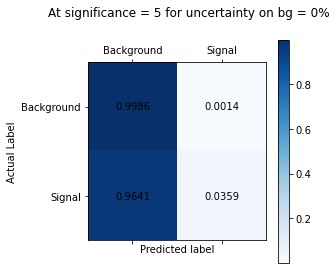

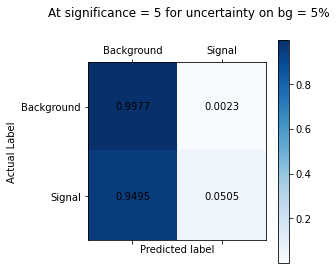

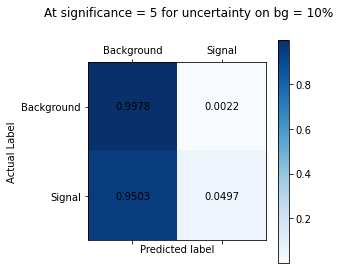

In [29]:
idx_0, idx_5, idx_10 = np.argmin(abs(5-significance_sigma0)), np.argmin(abs(5-significance_sigma5[:idx_5])), np.argmin(abs(5-significance_sigma10[:idx_10]))
# print(f"Best threshold for sigma=0% is {thresholds[idx_0]} \nBest threshold for sigma=5% is {thresholds[idx_5]} \nBest threshold for sigma=10% is {thresholds[idx_10]}")
label = {0: 0, 1: 5, 2:10}
# idx_sig5 = np.argmin(abs(significance_sigma10-5))

for j, idx in enumerate((idx_0, idx_5, idx_10)):
    conf_mat = [[1-fpr[idx], fpr[idx]], [1-tpr[idx], tpr[idx]]]
    plt.matshow(conf_mat, cmap='Blues')
    for (x, y), value in np.ndenumerate(conf_mat):
        plt.text(y, x, f"{value:.4f}", va="center", ha="center")
    plt.xlabel('Predicted label')
    plt.ylabel('Actual Label')
    plt.xticks([0,1], labels=['Background', 'Signal'])
    plt.yticks([0,1], labels=['Background', 'Signal'])
    plt.colorbar()
    plt.suptitle(f"At significance = 5 for uncertainty on bg = {label[j]}%")
    # plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}_sig_5.png", dpi=200)
    plt.show()

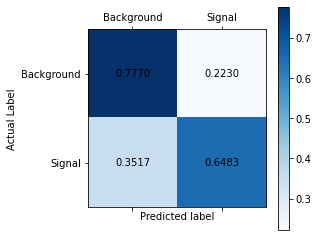

In [38]:
conf_mat = [[1-fpr[best_f1_idx], fpr[best_f1_idx]], [1-tpr[best_f1_idx], tpr[best_f1_idx]]]
plt.matshow(conf_mat, cmap='Blues')
for (x, y), value in np.ndenumerate(conf_mat):
    plt.text(y, x, f"{value:.4f}", va="center", ha="center")
plt.xlabel('Predicted label')
plt.ylabel('Actual Label')
plt.xticks([0,1], labels=['Background', 'Signal'])
plt.yticks([0,1], labels=['Background', 'Signal'])
plt.colorbar()
# plt.suptitle(f"At significance = {thresholds[best_f1_idx]}")
# plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}_sig_5.png", dpi=200)
plt.show()

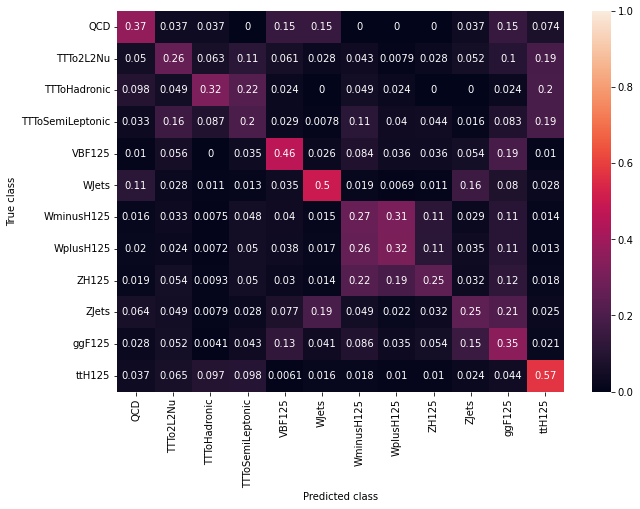

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  

y_pred = combined_model.predict([X_test_obj, X_test_event])
predictions = np.argmax(y_pred, axis=1)
true = np.argmax(y_test.values, axis=1)
cm = confusion_matrix(true, predictions, normalize='true')
columns = ['QCD', 'TTTo2L2Nu',  'TTToHadronic',  'TTToSemiLeptonic',  'VBF125' , 'WJets', 'WminusH125',  'WplusH125',  'ZH125',  'ZJets',  'ggF125',  'ttH125']
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, xticklabels=columns, yticklabels=columns, vmin=0, vmax=1)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
  

In [52]:
y_pred

array([[2.7459401e-03, 3.7042729e-09, 8.4306425e-01, 1.5418974e-01],
       [2.9939006e-03, 6.2359535e-09, 9.0220255e-01, 9.4803594e-02],
       [1.9593609e-03, 8.0458368e-10, 6.1679381e-01, 3.8124683e-01],
       ...,
       [2.2407763e-03, 1.3647706e-09, 9.4883978e-01, 4.8919346e-02],
       [3.8280592e-05, 2.8234746e-14, 8.7633338e-03, 9.9119836e-01],
       [1.8585451e-03, 1.4443054e-10, 9.9275148e-01, 5.3900494e-03]],
      dtype=float32)

In [35]:
print(significance_sigma10[-180:])

[ 3.91412823  3.91909976  3.91824404  3.9304403   3.94173697  3.95038479
  3.96617213  3.97042517  3.9681621   3.96589509  3.97827927  3.98425927
  3.981225    4.00366023  4.0128373   4.02924058  4.03348468  4.03950113
  4.04008327  4.04003     4.0519746   4.04524623  4.06432947  4.07402204
  4.10195885  4.11421805  4.11888584  4.13290519  4.12595394  4.1377259
  4.13469116  4.15769136  4.18823943  4.18112732  4.210555    4.22232173
  4.23420449  4.26027888  4.27150533  4.28684424  4.29829166  4.30302157
  4.30860729  4.33450851  4.35777881  4.37944897  4.38626014  4.41142616
  4.43524311  4.45124056  4.44939068  4.48081266  4.48422496  4.49478139
  4.50316562  4.5102769   4.52013222  4.51926974  4.53012996  4.56023947
  4.56992736  4.58721855  4.59769963  4.62238942  4.62822134  4.63778871
  4.65684589  4.66095794  4.69562545  4.70319345  4.71562129  4.72528006
  4.7258038   4.71689358  4.72836224  4.74094595  4.78249347  4.8025202
  4.79414397  4.80058633  4.83645792  4.8402455   4.8